# ONLINE RETAIL CUSTOMER SEGMENTATION WITH K-MEANS

Overview

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

We will be using the online retail trasnational dataset to build a RFM clustering and choose the best set of customers.RFM stands for RECENCY, where this explains when did the customer last purchase or visit the store. For example if Recency is 30 days then the customer has not been to the Store or Purchased anything in the last 30 days. FREQUENCY is how many times the customer has purchased in the store. For Example if the Frequncy is 50 it means the customer has made 50 purchases. MONETARY, this is how much the customer has spent on the Store. 

In [1]:
#First we will beginning by importing all the necessary libraries for the task


import pandas as pd
import numpy as np
# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import scale

# To perform KMeans clustering 
from sklearn.cluster import KMeans


### Read in the Data

In [2]:
#reading Dataset
retail = pd.read_csv("Online+Retail.csv",  sep = ',',encoding = "ISO-8859-1", header= 0)

# parse date
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format = "%d-%m-%Y %H:%M")

In [3]:
#Let's Check a Sample of our Data
retail.sample(7)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
111126,545713,22666,RECIPE BOX PANTRY YELLOW DESIGN,14,2011-03-07 10:11:00,6.63,NaN,United Kingdom
272109,560732,22619,SET OF 6 SOLDIER SKITTLES,2,2011-07-20 14:55:00,3.75,14056.0,United Kingdom
353902,567852,22847,BREAD BIN DINER STYLE IVORY,40,2011-09-22 13:21:00,11.67,18102.0,United Kingdom
29909,538830,22962,JAM JAR WITH PINK LID,24,2010-12-14 13:01:00,0.72,14298.0,United Kingdom
140547,548409,22662,LUNCH BAG DOLLY GIRL DESIGN,10,2011-03-31 10:27:00,1.65,12731.0,France
541345,581498,21218,RED SPOTTY BISCUIT TIN,4,2011-12-09 10:26:00,8.29,NaN,United Kingdom
93386,544293,21213,PACK OF 72 SKULL CAKE CASES,3,2011-02-17 12:42:00,0.55,17954.0,United Kingdom


In [4]:
#We Will the Look at Some Simple Descriptive Statistics of our Data

retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
#our Data has over 500, 000 thousand Rows and 8 features
retail.shape

(541909, 8)

In [6]:
#A quick OverView of the Data
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


From the Info Summary Above of the Data Set We can see that there are some Missing Values and We have to Take of Them Later.

In [7]:
retail.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Since, Customer Id is Missing Some Values, there is nothing much we can do but to drop all of them. Each Customer has a Unique Id and trying to fill in the values will impact our results

In [8]:
orders = retail.dropna()

In [9]:
orders.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [10]:
orders.shape

(406829, 8)

Looking Above We have Dropped all the Missing Values and our Data Set has Reduced to Over 400K Rows and still Has 8 Features.

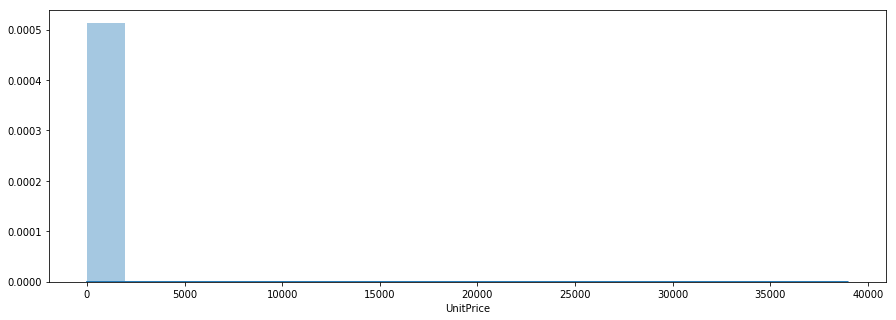

In [11]:
#Let's See the Distribution of Price
fig = plt.figure(figsize=(15,5))
sns.distplot(orders['UnitPrice'],bins=20)

When Our Data is the Above Format, it isn't of Much Help To Us Since We want to Segment the Customers and the Data is in the form of orders where it shows the Quantity that they ordered and the Unit Price, We can use this Information To create New Features.

## Feature Engineering 

Extracting R(Recency), F(Frequency), M(Monetary) columns 

In [12]:
orders.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [13]:
#RFM implementation

# Extracting amount by multiplying quantity and unit price and saving the data into amount variable.
amount  = pd.DataFrame(orders.Quantity * orders.UnitPrice, columns = ["Amount"])
amount.head()

,Amount
0,15.30
1,20.34
2,22.00
3,20.34
4,20.34


We First Begin By Extracting the Monetary Value 

#### Monetary Value

MONETARY, this is how much the customer has spent on the Store.

In [14]:
#Merging the Amount in the Order
orders = pd.concat(objs=[orders,amount],axis=1,ignore_index=False)

#When then Find the Total Amount that Each Customer Spent
monetary = orders.groupby('CustomerID')['Amount'].sum().reset_index()


In [15]:
monetary.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


#### FREQUENCY 

FREQUENCY is how many times the customer has purchased in the store. For Example if the Frequncy is 50 it means the customer has made 50 purchases.

In [17]:
#Frequency function
frequency = orders[['CustomerID', 'InvoiceNo']]

In [18]:
#Here We get the Count of Orders that Each Customer Made 
k = frequency.groupby('CustomerID')['InvoiceNo'].count()
k = pd.DataFrame(k).reset_index()
k.columns = ["CustomerID", "Frequency"]

In [19]:
k.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [20]:
k.shape

(4372, 2)

### MERGE THE AMOUNT AND FREQUENCY

In [21]:
orders.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Amount'],
      dtype='object')

In [22]:
#creating master dataset
master = monetary.merge(k, on = "CustomerID", how = "inner")
master.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


### RECENCY

RECENCY, where this explains when did the customer last purchase or visit the store. For example if Recency is 30 days then the customer has not been to the Store or Purchased anything in the last 30 days. 

In [23]:
recency  = orders[['CustomerID','InvoiceDate']]
maximum = max(recency.InvoiceDate)

In [24]:
maximum

Timestamp('2011-12-09 12:50:00')

In [25]:
#Generating recency function

# Adding one more day to the max data, so that the max date will have 1 as the difference and not zero.
maximum = maximum + pd.DateOffset(days=1)
recency['diff'] = maximum - recency.InvoiceDate
recency.head()

C:\Users\control\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,CustomerID,InvoiceDate,diff
0,17850.0,2010-12-01 08:26:00,374 days 04:24:00
1,17850.0,2010-12-01 08:26:00,374 days 04:24:00
2,17850.0,2010-12-01 08:26:00,374 days 04:24:00
3,17850.0,2010-12-01 08:26:00,374 days 04:24:00
4,17850.0,2010-12-01 08:26:00,374 days 04:24:00


In [26]:
# recency by customerid
a = recency.groupby('CustomerID')
a.diff.min()

CustomerID
12346.0   326 days 02:33:00
12347.0     2 days 20:58:00
12348.0    75 days 23:37:00
12349.0    19 days 02:59:00
12350.0   310 days 20:49:00
12352.0    36 days 22:13:00
12353.0   204 days 19:03:00
12354.0   232 days 23:39:00
12355.0   214 days 23:01:00
12356.0    23 days 04:10:00
12357.0    33 days 20:43:00
12358.0     2 days 02:24:00
12359.0     8 days 01:29:00
12360.0    52 days 21:28:00
12361.0   287 days 22:59:00
12362.0     3 days 21:10:00
12363.0   110 days 02:32:00
12364.0     8 days 02:28:00
12365.0   291 days 22:46:00
12367.0     4 days 20:02:00
12370.0    51 days 21:59:00
12371.0    45 days 02:34:00
12372.0    72 days 00:38:00
12373.0   311 days 23:40:00
12374.0    25 days 21:13:00
12375.0     3 days 01:23:00
12377.0   315 days 21:05:00
12378.0   130 days 02:16:00
12379.0    82 days 02:41:00
12380.0    22 days 01:23:00
                 ...       
18245.0     7 days 22:02:00
18246.0    24 days 01:01:00
18248.0   114 days 06:36:00
18249.0    17 days 21:43:00
18250.0  

In [27]:
#Dataframe merging by recency
df = pd.DataFrame(recency.groupby('CustomerID').diff.min())
df = df.reset_index()
df.columns = ["CustomerID", "Recency"]
df.head()

,CustomerID,Recency
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


   WE THEN COMBINE ALL THE DATAFRAMES THAT WE HAVE CREATED 

In [28]:
#Combining all recency, frequency and monetary parameters
RFM = k.merge(monetary, on = "CustomerID")
RFM = RFM.merge(df, on = "CustomerID")
RFM.head()

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
1,12347.0,182,4310.00,2 days 20:58:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00


In [29]:
RFM.shape

(4372, 4)

WHEN IT COMES TO K=MEANS CLUSTERING THE OUTLIER HEAVILY IMPACTS THE RESULTS SO WE HAVE TO ENSURE WE REMOVE ANY OUTLIERS IN OUR DATASET

{'whiskers': [<matplotlib.lines.Line2D at 0x2cf1db9d8d0>,
 'caps': [<matplotlib.lines.Line2D at 0x2cf1d839390>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cf1df908d0>],
 'medians': [<matplotlib.lines.Line2D at 0x2cf1d839a20>],
 'fliers': [<matplotlib.lines.Line2D at 0x2cf1d839d68>],
 'means': []}

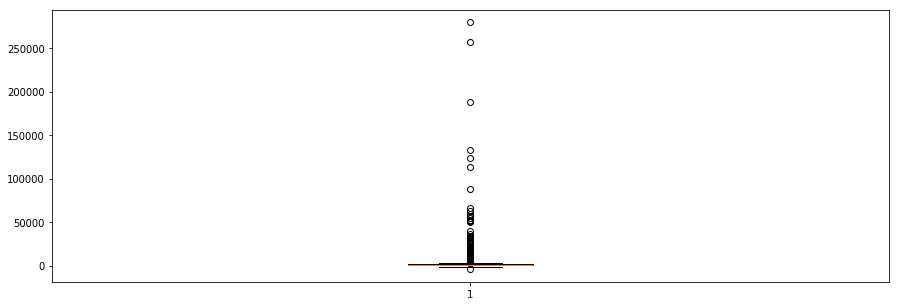

In [31]:
#Removing Outliers for the Amount
fig = plt.figure(figsize=(15,5))
plt.boxplot(RFM.Amount)


In [32]:
Q1 = RFM.Amount.quantile(0.25)
Q3 = RFM.Amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Amount >= Q1 - 1.5*IQR) & (RFM.Amount <= Q3 + 1.5*IQR)]

{'whiskers': [<matplotlib.lines.Line2D at 0x2cf1de1f5c0>,
 'caps': [<matplotlib.lines.Line2D at 0x2cf1de1fc50>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cf1de1f198>],
 'medians': [<matplotlib.lines.Line2D at 0x2cf1d601320>],
 'fliers': [<matplotlib.lines.Line2D at 0x2cf1d601668>],
 'means': []}

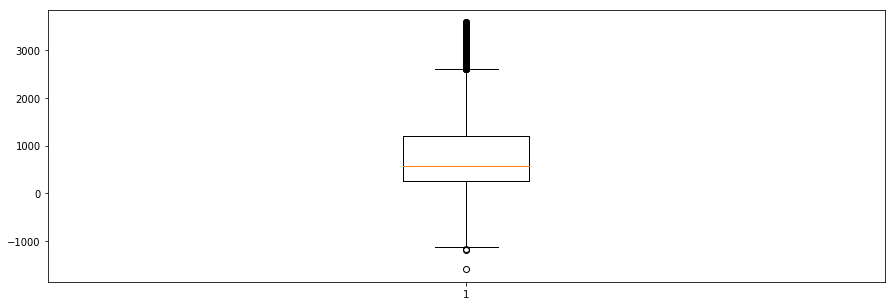

In [33]:
fig = plt.figure(figsize=(15,5))
plt.boxplot(RFM.Amount)


{'whiskers': [<matplotlib.lines.Line2D at 0x2cf1d7d9390>,
 'caps': [<matplotlib.lines.Line2D at 0x2cf1e117ef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cf1e117470>],
 'medians': [<matplotlib.lines.Line2D at 0x2cf1dc975c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2cf1dc97588>],
 'means': []}

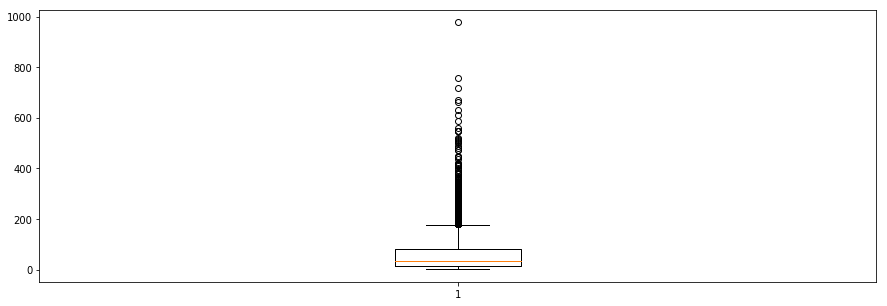

In [34]:
# outlier treatment for Frequency
fig = plt.figure(figsize=(15,5))
plt.boxplot(RFM.Frequency)

In [35]:
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

{'whiskers': [<matplotlib.lines.Line2D at 0x2cf1e0cd160>,
 'caps': [<matplotlib.lines.Line2D at 0x2cf1cccb6a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cf1ccbbbe0>],
 'medians': [<matplotlib.lines.Line2D at 0x2cf1cccbd30>],
 'fliers': [<matplotlib.lines.Line2D at 0x2cf1cccbe10>],
 'means': []}

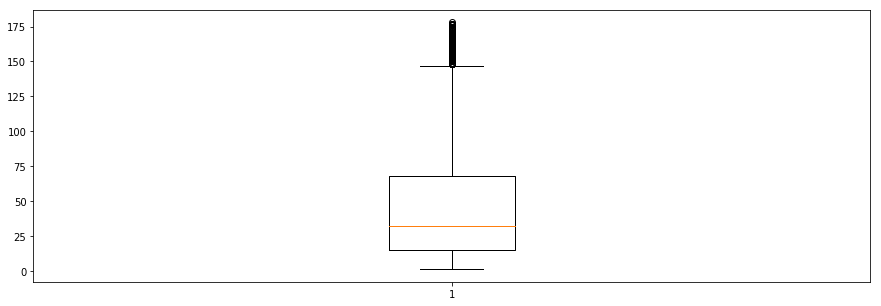

In [36]:
fig = plt.figure(figsize=(15,5))
plt.boxplot(RFM.Frequency)

{'whiskers': [<matplotlib.lines.Line2D at 0x2cf1e21ac88>,
 'caps': [<matplotlib.lines.Line2D at 0x2cf16f31898>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cf1e229dd8>],
 'medians': [<matplotlib.lines.Line2D at 0x2cf16f31f28>],
 'fliers': [<matplotlib.lines.Line2D at 0x2cf16f3a2b0>],
 'means': []}

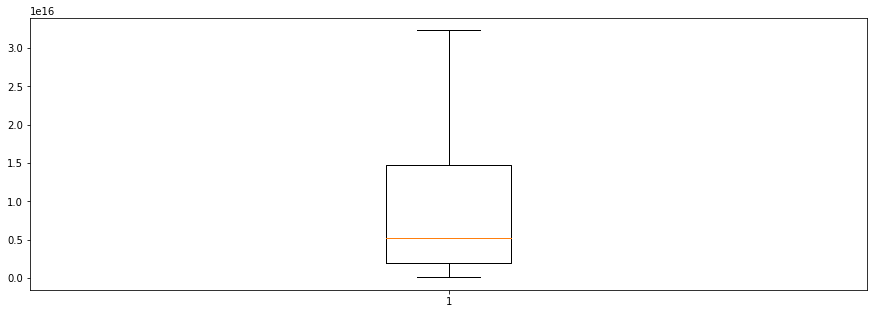

In [37]:
# outlier treatment for Recency
fig = plt.figure(figsize=(15,5))
plt.boxplot(RFM.Recency)

In [38]:
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

{'whiskers': [<matplotlib.lines.Line2D at 0x2cf16f5f3c8>,
 'caps': [<matplotlib.lines.Line2D at 0x2cf17088518>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cf17080a58>],
 'medians': [<matplotlib.lines.Line2D at 0x2cf17088ba8>],
 'fliers': [<matplotlib.lines.Line2D at 0x2cf17088ef0>],
 'means': []}

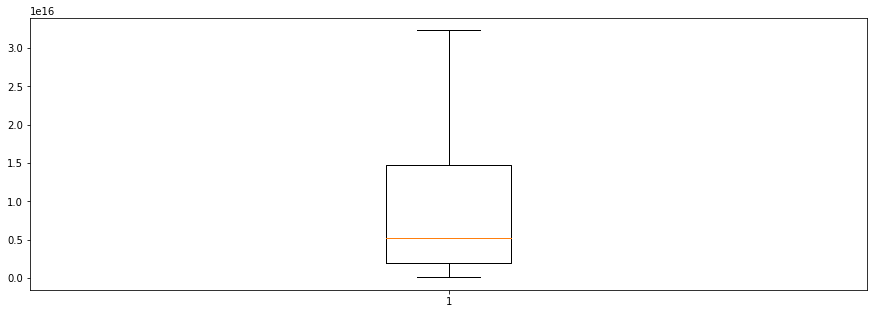

In [39]:
fig = plt.figure(figsize=(15,5))
plt.boxplot(RFM.Recency)

In [40]:
RFM.shape

(3697, 4)

We can See that We have Removed Some Outliers by When we Checked the Shape of our Data, The Rows have Dropped From Around 4K to around 3600

In [41]:
RFM.head()

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00
5,12352.0,95,1545.41,36 days 22:13:00


Before, We Can Proceed We have to Performing Standard Scaling On Our Data To Esure they Fall at the same scale where the mean is Zero and the Standard Deviation is 1

For Recency We also need the number of days as that is the Most Useful Since Our data is for only a year

In [42]:
# standardise all parameters
RFM_norm1 = RFM.drop("CustomerID", axis=1)
RFM_norm1.Recency = RFM_norm1.Recency.dt.days

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)

In [43]:
RFM_norm1 = pd.DataFrame(RFM_norm1)
RFM_norm1.columns = ['Frequency','Amount','Recency']
RFM_norm1.head()

,Frequency,Amount,Recency
0,-1.070949,-1.041614,2.136422
1,-0.375498,1.385298,-0.282050
2,0.631707,1.331702,-0.821629
3,-0.711233,-0.590055,1.982257
4,1.159290,1.045238,-0.657828


# HOPKINS STATISTICS

The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

If the value is between {0.01, ...,0.3}, the data is regularly spaced.

If the value is around 0.5, it is random.

If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [44]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [45]:
hopkins(RFM_norm1)

0.8850737091740732

Since, Our Hopkins Value is High Clustreing will Work Very Well.

# MODELLING WITH K-MEANS

In [47]:
inertia = []
for n in range(1 , 21):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='auto',n_jobs=-1) )
    algorithm.fit(RFM_norm1)
    inertia.append(algorithm.inertia_)

(Text(0.5, 0, 'Number of Clusters'), Text(0, 0.5, 'Inertia'))

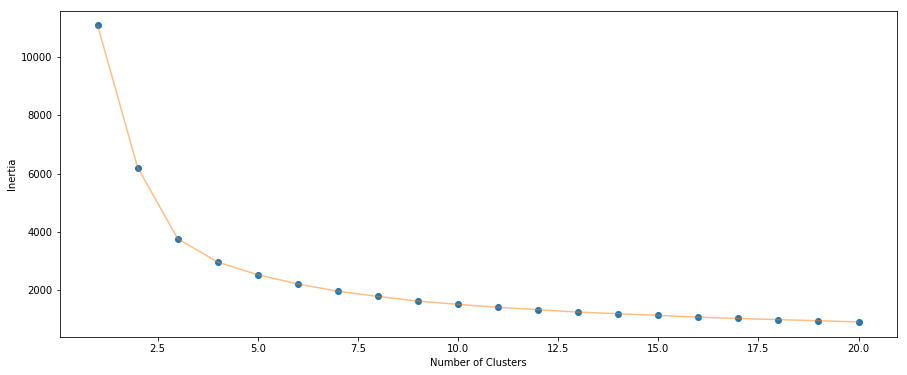

In [49]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 21) , inertia , 'o')
plt.plot(np.arange(1 , 21) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')

In [50]:
import cufflinks as cf
cf.go_offline()

In [52]:
#Used For interactive Visuals
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected = True)

In [51]:
RFM_norm1.columns

Index(['Frequency', 'Amount', 'Recency'], dtype='object')

In [53]:
algorithm = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='auto',n_jobs=-1) )
algorithm.fit(RFM_norm1)
labels = algorithm.labels_
centroids = algorithm.cluster_centers_

In [54]:
labels

array([3, 0, 0, ..., 3, 2, 0])

In [55]:
centroids

array([[ 0.16552464,  0.580068  , -0.52182518],
       [ 1.70817545,  2.29565655, -0.63664075],
       [-0.55929424, -0.56004948, -0.44983987],
       [-0.62588763, -0.5999978 ,  1.52355489],
       [ 1.61545303,  0.19066207, -0.48457557]])

In [66]:
RFM['labels'] =  labels
trace1 = go.Scatter3d(
    x= RFM['Frequency'],
    y= RFM['Amount'],
    z= RFM['Recency'],
    mode='markers',
     marker=dict(
        color = RFM['labels'], 
        size= 20,
        line=dict(
            color= RFM['labels'],
            width= 12
        ),
        opacity=0.8
     )
)
data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Frequency'),
            yaxis = dict(title  = 'Amount'),
            zaxis = dict(title  = 'Recency')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [67]:
RFM.head(20)

,CustomerID,Frequency,Amount,Recency,labels
0,12346.0,2,0.00,326 days 02:33:00,3
2,12348.0,31,1797.24,75 days 23:37:00,0
3,12349.0,73,1757.55,19 days 02:59:00,0
4,12350.0,17,334.40,310 days 20:49:00,3
5,12352.0,95,1545.41,36 days 22:13:00,4
6,12353.0,4,89.00,204 days 19:03:00,3
7,12354.0,58,1079.40,232 days 23:39:00,3
8,12355.0,13,459.40,214 days 23:01:00,3
9,12356.0,59,2811.43,23 days 04:10:00,1
11,12358.0,19,1168.06,2 days 02:24:00,0


In [65]:
RFM.head()

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00
5,12352.0,95,1545.41,36 days 22:13:00


In [70]:
# analysis of clusters formed
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM, pd.Series(algorithm.labels_)], axis=1)
RFM_km.columns = ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID','Lables2']

RFM_km.Recency = RFM_km.Recency.dt.days
km_clusters_amount = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

In [71]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,1201.448994,53.668613,50.119708
1,1,2471.402482,117.888283,38.198910
2,2,357.594530,23.325785,57.572681
3,3,327.037096,20.558856,262.393839
4,4,912.557139,114.021798,53.980926


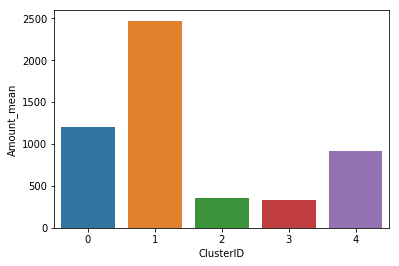

In [72]:
sns.barplot(x=df.ClusterID, y=df.Amount_mean)

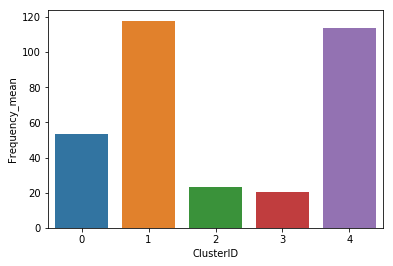

In [73]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

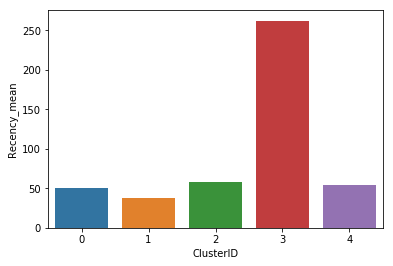

In [74]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)

In [75]:
RFM.head()

,CustomerID,Frequency,Amount,Recency,labels
0,12346.0,2,0.00,326 days 02:33:00,3
1,12348.0,31,1797.24,75 days 23:37:00,0
2,12349.0,73,1757.55,19 days 02:59:00,0
3,12350.0,17,334.40,310 days 20:49:00,3
4,12352.0,95,1545.41,36 days 22:13:00,4


In [76]:
RFM_km.head()

,CustomerID,Frequency,Amount,Recency,ClusterID,Lables2
0,12346.0,2,0.00,326,3,3
1,12348.0,31,1797.24,75,0,0
2,12349.0,73,1757.55,19,0,0
3,12350.0,17,334.40,310,3,3
4,12352.0,95,1545.41,36,4,4


In [77]:
RFM_norm1.head()

,Frequency,Amount,Recency,labels
0,-1.070949,-1.041614,2.136422,3
1,-0.375498,1.385298,-0.282050,0
2,0.631707,1.331702,-0.821629,0
3,-0.711233,-0.590055,1.982257,3
4,1.159290,1.045238,-0.657828,4


From the Above Clusters we can See that the customers grouped in cluster 1 have a tendecy to spend more there the company can put more focus on them by maybe giving more offers or discounts to ensure they keep coming. The Same for Cluster 4 They don't spend much so we can sent them email giving them more discounts maybe to lure them to buy more. Depending on what the Retail Store Wants.